In [1]:
import json
import os
import re
from math import log2, pi
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import qiskit.result
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from scipy.spatial import distance
from tqdm import tqdm

%config InlineBackend.figure_format = 'svg'

## Circuit for Hamming distance calculation

In [2]:
def hamdist_circuit(n_data_qubits, n_auxilia_qubits, lite=False):
    """Quantum circuit for  Hamming distance calculation"""
    qrx = QuantumRegister(n_data_qubits, "x")
    qry = QuantumRegister(n_data_qubits, "y")
    qra = QuantumRegister(n_auxilia_qubits, "a")
    circ = QuantumCircuit(qrx, qry, qra, name="Hamming distance")

    # Ecncoding
    circ.cx(qry, qrx)

    # Extraction
    circ.barrier()
    if qra.size == 1:
        circ.h(qra)
        circ.crz(pi / n_data_qubits, qrx, qra)
        circ.h(qra)

    elif qra.size > 1 and qrx.size == 4:
        circ.h(qra[0])
        circ.crz(pi / n_data_qubits, qrx[: n_data_qubits // 2], qra[0])
        for i in range(qra.size - 1):
            circ.swap(qra[i + 1], qra[i])
        circ.crz(pi / n_data_qubits, qrx[n_data_qubits // 2 :], qra[-1])
        circ.h(qra[-1])

    elif qra.size > 1 and qrx.size == 5:
        circ.h(qra[0])
        circ.crz(pi / qrx.size, qrx[: qrx.size // 2], qra[0])
        for i in range(qra.size // 2):
            circ.swap(qra[i + 1], qra[i])
        circ.crz(pi / qrx.size, qrx[qrx.size // 2], qra[qra.size // 2])
        for i in range(qra.size // 2, qra.size - 1):
            circ.swap(qra[i + 1], qra[i])
        circ.crz(pi / qrx.size, qrx[qrx.size // 2 + 1 :], qra[-1])
        circ.h(qra[-1])

    elif qra.size > 1 and qrx.size == 8:
        circ.h(qra[0])
        circ.crz(pi / qrx.size, qrx[:2], qra[0])

        for j in range(4):
            i_ancilla = 2 * j
            for i in range(2):
                circ.swap(qra[i_ancilla + i + 1], qra[i_ancilla + i])
            circ.crz(pi / qrx.size, qrx[j + 2], qra[i_ancilla + 2])

        for i in range(2):
            circ.swap(qra[qra.size - 2 + i], qra[qra.size - 3 + i])
        circ.crz(pi / qrx.size, qrx[qrx.size - 3 :], qra[-1])
        circ.h(qra[-1])
    else:
        raise NotImplementedError(f"to many ancilas: {n_auxilia_qubits}")

    # Decoding
    circ.barrier()
    if not lite:
        circ.cx(qry, qrx)

    return circ

### Example with 3 data qubits and single auxilia qubits

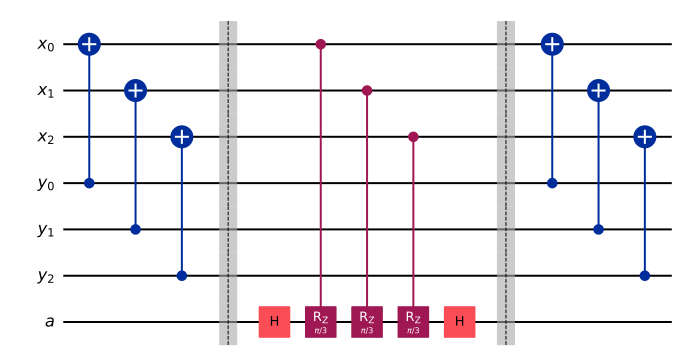

In [3]:
hamdist_circuit(3, 1, False).draw(output="mpl")

**Decomposed**

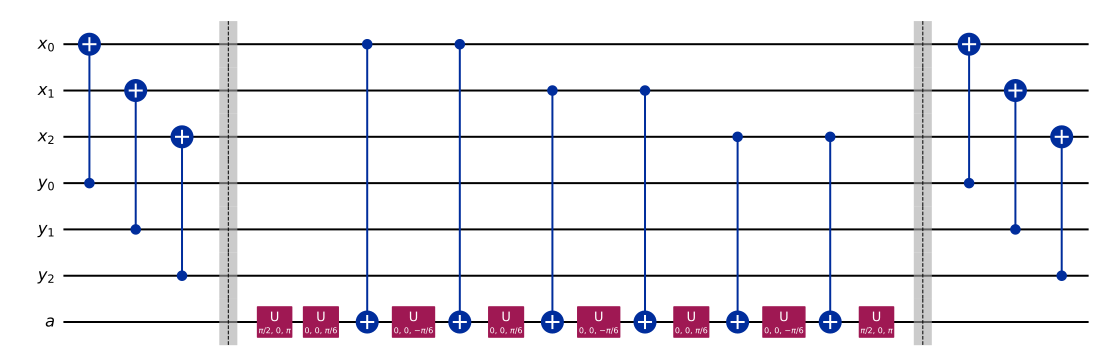

In [4]:
hamdist_circuit(3, 1, False).decompose(reps=6).draw(output="mpl")

#### Figure of circuit for paper

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


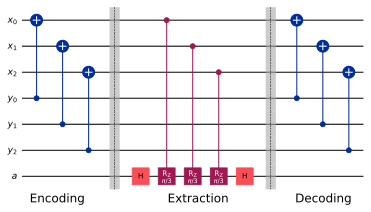

In [5]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1)

style = {
    "fontsize": 14,
    "subfontsize": 12,
    "backgroundcolor": "white",
    "margin": [1.35, 0, 0, 0],
}

hamdist_circuit(3, 1, False).draw(ax=ax, style=style, output="mpl")

ax.text(-0.5, -7, "Encoding", fontsize=12)
ax.text(4.8, -7, "Extraction", fontsize=12)
ax.text(9.7, -7, "Decoding", fontsize=12)

fig.set_facecolor("white")
fig.savefig("hd-circuit-n3a1.eps", bbox_inches="tight")
fig.savefig("hd-circuit-n3a1.pdf", bbox_inches="tight")

### Example with 4 data qubits and 3 auxilia qubits

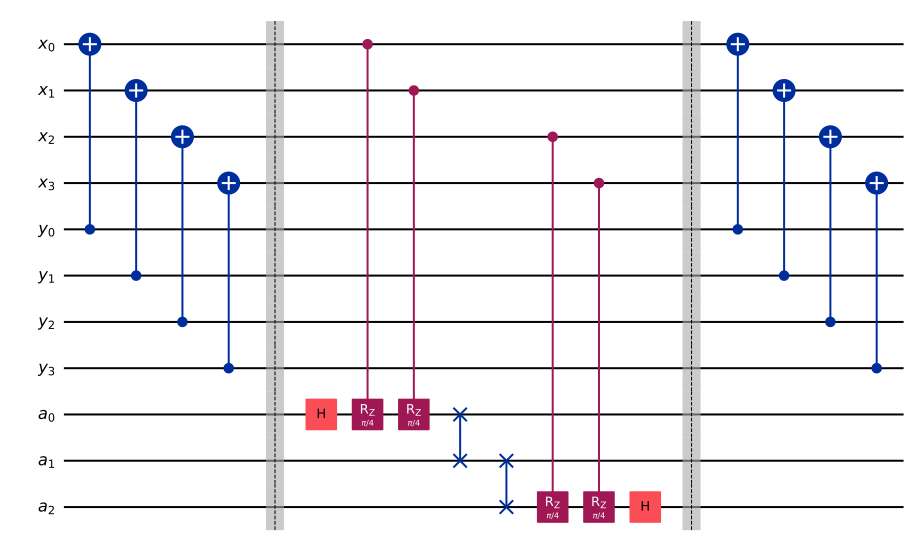

In [6]:
hamdist_circuit(4, 3, False).draw(output="mpl")

#### Figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


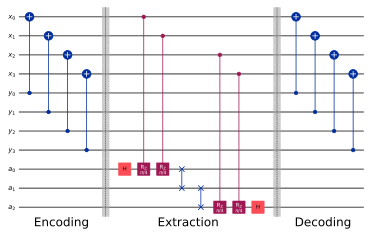

In [7]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1)

style = {
    "fontsize": 14,
    "subfontsize": 12,
    "backgroundcolor": "white",
    "margin": [1.4, 0, 0, 0],
}

hamdist_circuit(4, 3, False).draw(ax=ax, style=style, output="mpl")

ax.text(0, -11, "Encoding", fontsize=12)
ax.text(6.5, -11, "Extraction", fontsize=12)
ax.text(13.7, -11, "Decoding", fontsize=12)

fig.set_facecolor("white")
fig.savefig("hd-circuit-n4a3.eps", bbox_inches="tight")
fig.savefig("hd-circuit-n4a3.pdf", bbox_inches="tight")
fig.savefig("hd-circuit-n4a3.png", bbox_inches="tight")

### Figure with single ancilla

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


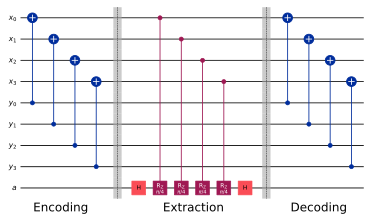

In [8]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1)

style = {
    "fontsize": 14,
    "subfontsize": 12,
    "backgroundcolor": "white",
    "margin": [1.4, 0, 0, 0],
}

hamdist_circuit(4, 1, False).draw(ax=ax, style=style, output="mpl")

ax.text(-0.2, -9.1, "Encoding", fontsize=12)
ax.text(5.9, -9.1, "Extraction", fontsize=12)
ax.text(11.9, -9.1, "Decoding", fontsize=12)

fig.set_facecolor("white")
fig.savefig("hd-circuit-n4a3.eps", bbox_inches="tight")
fig.savefig("hd-circuit-n4a3.pdf", bbox_inches="tight")
fig.savefig("hd-circuit-n4a3.png", bbox_inches="tight")

### Example with 5 data qubits and 5 auxilia qubits

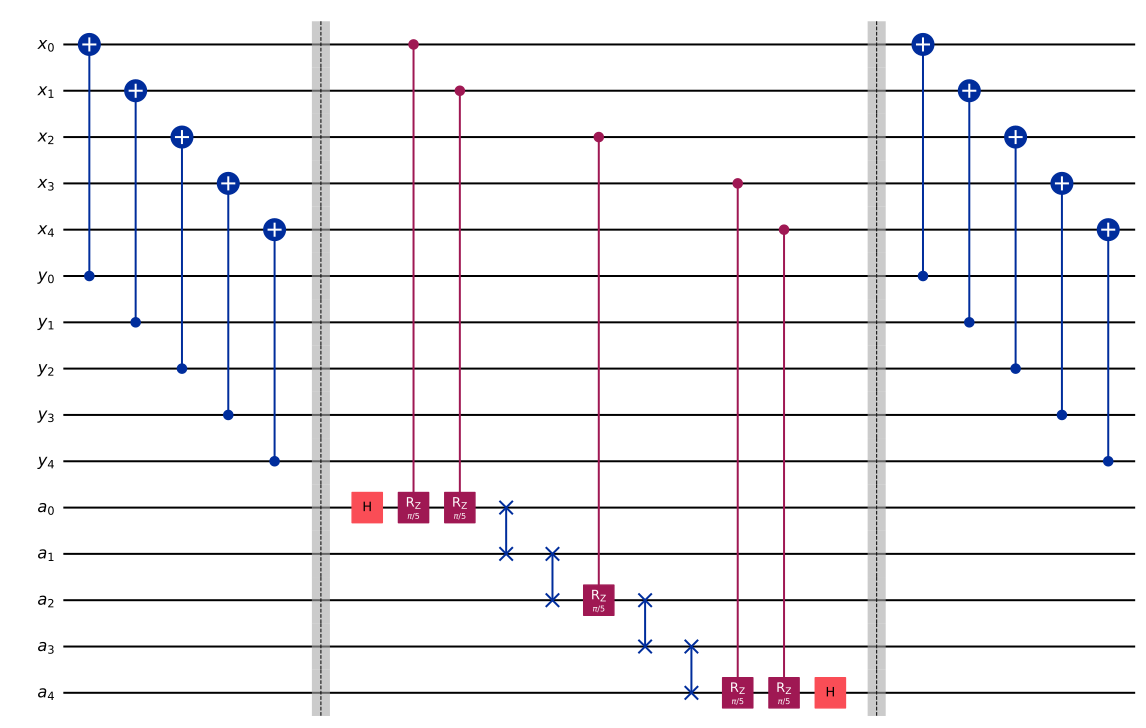

In [9]:
hamdist_circuit(5, 5, False).draw(output="mpl")

#### Figure of circuit for paper

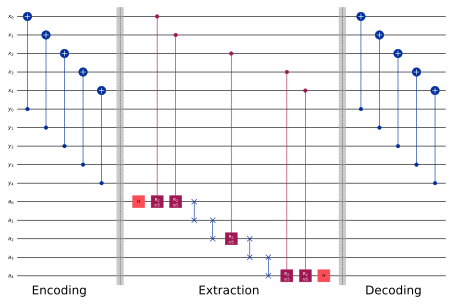

In [10]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1)

style = {
    "fontsize": 14,
    "subfontsize": 12,
    "backgroundcolor": "white",
    "margin": [1.3, 0, 0, 0],
}

hamdist_circuit(5, 5, False).draw(ax=ax, style=style, output="mpl")

ax.text(0, -15, "Encoding", fontsize=12)
ax.text(9, -15, "Extraction", fontsize=12)
ax.text(18, -15, "Decoding", fontsize=12)

fig.set_facecolor("white")
fig.tight_layout()
fig.savefig(f"hd-circuit-n5a5.png", bbox_inches="tight", dpi=200)

### Example with 8 data qubits and 11 auxilia qubits

In [11]:
hamdist_circuit(8, 11, False).draw(fold=-1)

┌───┐                                    ░                                                                                                                                             ░ ┌───┐                                   
 x_0: ┤ X ├────────────────────────────────────░───────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤ X ├───────────────────────────────────
      └─┬─┘┌───┐                               ░           │                                                                                                                                 ░ └─┬─┘┌───┐                              
 x_1: ──┼──┤ X ├───────────────────────────────░───────────┼──────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───┼──┤ X ├──────────────────────────────
        │  └─┬─┘┌───┐                          ░           │          │                                                                                                                      ░   │  └─┬─┘┌───┐                         
 x_2: ──┼────┼──┤ X ├──────────────────────────░───────────┼──────────┼────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────░───┼────┼──┤ X ├─────────────────────────
        │    │  └─┬─┘┌───┐                     ░           │          │                │                                                                                                     ░   │    │  └─┬─┘┌───┐                    
 x_3: ──┼────┼────┼──┤ X ├─────────────────────░───────────┼──────────┼────────────────┼────────────────■────────────────────────────────────────────────────────────────────────────────────░───┼────┼────┼──┤ X ├────────────────────
        │    │    │  └─┬─┘┌───┐                ░           │          │                │                │                                                                                    ░   │    │    │  └─┬─┘┌───┐               
 x_4: ──┼────┼────┼────┼──┤ X ├────────────────░───────────┼──────────┼────────────────┼────────────────┼────────────────■───────────────────────────────────────────────────────────────────░───┼────┼────┼────┼──┤ X ├───────────────
        │    │    │    │  └─┬─┘┌───┐           ░           │          │                │                │                │                                                                   ░   │    │    │    │  └─┬─┘┌───┐          
 x_5: ──┼────┼────┼────┼────┼──┤ X ├───────────░───────────┼──────────┼────────────────┼────────────────┼────────────────┼────────────────■────────────────■─────────────────────────────────░───┼────┼────┼────┼────┼──┤ X ├──────────
        │    │    │    │    │  └─┬─┘┌───┐      ░           │          │                │                │                │                │                │                                 ░   │    │    │    │    │  └─┬─┘┌───┐     
 x_6: ──┼────┼────┼────┼────┼────┼──┤ X ├──────░───────────┼──────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼──────────■──────────────────────░───┼────┼────┼────┼────┼────┼──┤ X ├─────
        │    │    │    │    │    │  └─┬─┘┌───┐ ░           │          │                │                │                │                │                │          │                      ░   │    │    │    │    │    │  └─┬─┘┌───┐
 x_7: ──┼────┼────┼────┼────┼────┼────┼──┤ X ├─░───────────┼──────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼──────────┼──────────■───────────░───┼────┼────┼────┼────┼────┼────┼──┤ X ├
        │    │    │    │    │    │    │  └─┬─┘ ░           │          │                │                │                │                │                │          │          │           ░   │    │    │    │    │    │    │  └─┬─┘
 y_0: ──■────┼────┼────┼────┼────┼────┼────┼───░───────────┼──

## Curcuit for Hamming distance tomography

In [12]:
def _compile_stack(states):
    """
    Initialize stack from quantum states.

    Examples
    --------
    >>> _compile_stack([[0, 0]])
    array([1., 0., 0., 0.])

    >>> _compile_stack([[0, 0], [0, 1], [1, 0], [1, 1]])
    array([0.5, 0.5, 0.5, 0.5])
    """

    stack = np.zeros(2 ** len(states[0]))
    for state in states:
        stack[int("".join(map(str, state)), 2)] = 1

    return stack / np.sqrt(stack.sum())


def initialize_circuit(circ, states, reg):
    """Initialize state on register of circuit."""
    if isinstance(states, int):
        return circ.h(reg)
    stack = _compile_stack(states.tolist())
    if stack.all():
        return circ.h(reg)
    return circ.initialize(stack, reg)

In [13]:
def min_qubits_for_data_encoding(data):
    """
    Min number of qubits for data encoding.

    Data is a matrix where vectors stacked as rows.
    """
    return int(log2(data)) if isinstance(data, int) else data.shape[1]

In [14]:
def hamdist_tomography_circuit(x, y, n_auxilia_qubits, lite):
    """Create quantum circuit for hamming distance calculation."""
    n_data_qubits = min_qubits_for_data_encoding(x)

    # Acquire registers
    qrx = QuantumRegister(n_data_qubits, "x")
    qry = QuantumRegister(n_data_qubits, "y")
    qra = QuantumRegister(n_auxilia_qubits, "a")

    crx = ClassicalRegister(qrx.size, r"$x_c$")
    cry = ClassicalRegister(qry.size, r"$y_c$")
    cra = ClassicalRegister(1, r"$a_c$")

    circ = QuantumCircuit(qrx, qry, qra, crx, cry, cra)

    # Initialize circuit
    initialize_circuit(circ, x, qrx)
    initialize_circuit(circ, y, qry)

    # Apply Hamming distance gate
    circ.barrier()
    circ.append(
        hamdist_circuit(n_data_qubits, n_auxilia_qubits=qra.size, lite=lite),
        list(qrx) + list(qry) + list(qra),
    )

    ## Measure
    circ.barrier()
    if not lite:
        circ.measure(qrx, crx)
    circ.measure(qry, cry)
    circ.measure(qra[-1], cra)

    return circ

In [15]:
def hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits):
    name = f"hd_full_tomography-circuit-nd{n_data_qubits}-na{n_auxilia_qubits}"
    circ = hamdist_tomography_circuit(2**n_data_qubits, 2**n_data_qubits, n_auxilia_qubits, False)
    circ.name = name
    return circ

### Example of tomography circuit

In [16]:
hamdist_full_tomography_circuit(4, 3).decompose(reps=1).draw(fold=-1)

┌─────────┐ ░ ┌───┐                ░                                                              ░ ┌───┐                ░ ┌─┐                        
    x_0: ┤ U2(0,π) ├─░─┤ X ├────────────────░───────────■──────────────────────────────────────────────────░─┤ X ├────────────────░─┤M├────────────────────────
         ├─────────┤ ░ └─┬─┘┌───┐           ░           │                                                  ░ └─┬─┘┌───┐           ░ └╥┘┌─┐                     
    x_1: ┤ U2(0,π) ├─░───┼──┤ X ├───────────░───────────┼──────────■───────────────────────────────────────░───┼──┤ X ├───────────░──╫─┤M├─────────────────────
         ├─────────┤ ░   │  └─┬─┘┌───┐      ░           │          │                                       ░   │  └─┬─┘┌───┐      ░  ║ └╥┘┌─┐                  
    x_2: ┤ U2(0,π) ├─░───┼────┼──┤ X ├──────░───────────┼──────────┼────────────────■──────────────────────░───┼────┼──┤ X ├──────░──╫──╫─┤M├──────────────────
         ├─────────┤ ░   │    │  └─┬─┘┌───┐ ░           │          │                │                      ░   │    │  └─┬─┘┌───┐ ░  ║  ║ └╥┘┌─┐               
    x_3: ┤ U2(0,π) ├─░───┼────┼────┼──┤ X ├─░───────────┼──────────┼────────────────┼──────────■───────────░───┼────┼────┼──┤ X ├─░──╫──╫──╫─┤M├───────────────
         ├─────────┤ ░   │    │    │  └─┬─┘ ░           │          │                │          │           ░   │    │    │  └─┬─┘ ░  ║  ║  ║ └╥┘┌─┐            
    y_0: ┤ U2(0,π) ├─░───■────┼────┼────┼───░───────────┼──────────┼────────────────┼──────────┼───────────░───■────┼────┼────┼───░──╫──╫──╫──╫─┤M├────────────
         ├─────────┤ ░        │    │    │   ░           │          │                │          │           ░        │    │    │   ░  ║  ║  ║  ║ └╥┘┌─┐         
    y_1: ┤ U2(0,π) ├─░────────■────┼────┼───░───────────┼──────────┼────────────────┼──────────┼───────────░────────■────┼────┼───░──╫──╫──╫──╫──╫─┤M├─────────
         ├─────────┤ ░             │    │   ░           │          │                │          │           ░             │    │   ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
    y_2: ┤ U2(0,π) ├─░─────────────■────┼───░───────────┼──────────┼────────────────┼──────────┼───────────░─────────────■────┼───░──╫──╫──╫──╫──╫──╫─┤M├──────
         ├─────────┤ ░                  │   ░           │          │                │          │           ░                  │   ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
    y_3: ┤ U2(0,π) ├─░──────────────────■───░───────────┼──────────┼────────────────┼──────────┼───────────░──────────────────■───░──╫──╫──╫──╫──╫──╫──╫─┤M├───
         └─────────┘ ░                      ░ ┌───┐┌────┴────┐┌────┴────┐           │          │           ░                      ░  ║  ║  ║  ║  ║  ║  ║ └╥┘   
    a_0: ────────────░──────────────────────░─┤ H ├┤ Rz(π/4) ├┤ Rz(π/4) ├─X─────────┼──────────┼───────────░──────────────────────░──╫──╫──╫──╫──╫──╫──╫──╫────
                     ░                      ░ └───┘└─────────┘└─────────┘ │         │          │           ░                      ░  ║  ║  ║  ║  ║  ║  ║  ║    
    a_1: ────────────░──────────────────────░─────────────────────────────X──X──────┼──────────┼───────────░──────────────────────░──╫──╫──╫──╫──╫──╫──╫──╫────
                     ░                      ░                                │ ┌────┴────┐┌────┴────┐┌───┐ ░                      ░  ║  ║  ║  ║  ║  ║  ║  ║ ┌─┐
    a_2: ────────────░──────────────────────░────────────────────────────────X─┤ Rz(π/4) ├┤ Rz(π/4) ├┤ H ├─░──────────────────────░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
                     ░                      ░                                  └─────────┘└─────────┘└───┘ ░                      ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
$x_c$: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╬══╬══╬══╬══╬═
                                                                                                                                     0  1  2  3  ║  ║  ║  ║  ║ 
$y_c$: 4/

#### Save figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


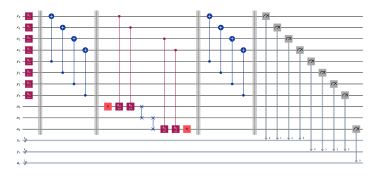

In [17]:
fig, ax = plt.subplots(1, 1)
circuit = hamdist_full_tomography_circuit(4, 3)
circuit.decompose(reps=1).draw(output="mpl", fold=-1, ax=ax)
fig.savefig(f"{circuit.name}.png", bbox_inches="tight")
fig.savefig(f"{circuit.name}.pdf", bbox_inches="tight")
fig.savefig(f"{circuit.name}.eps", bbox_inches="tight")

## Example of tomography on ideal simulator with 3 data qubits

In [18]:
n_data_qubits, n_auxilia_qubits = 3, 1

In [19]:
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=1)
circuit.draw(fold=-1, idle_wires=False)

┌─────────┐ ░ ┌───┐           ░                                             ░ ┌───┐           ░ ┌─┐                  
    x_0: ┤ U2(0,π) ├─░─┤ X ├───────────░───────────■─────────────────────────────────░─┤ X ├───────────░─┤M├──────────────────
         ├─────────┤ ░ └─┬─┘┌───┐      ░           │                                 ░ └─┬─┘┌───┐      ░ └╥┘┌─┐               
    x_1: ┤ U2(0,π) ├─░───┼──┤ X ├──────░───────────┼──────────■──────────────────────░───┼──┤ X ├──────░──╫─┤M├───────────────
         ├─────────┤ ░   │  └─┬─┘┌───┐ ░           │          │                      ░   │  └─┬─┘┌───┐ ░  ║ └╥┘┌─┐            
    x_2: ┤ U2(0,π) ├─░───┼────┼──┤ X ├─░───────────┼──────────┼──────────■───────────░───┼────┼──┤ X ├─░──╫──╫─┤M├────────────
         ├─────────┤ ░   │    │  └─┬─┘ ░           │          │          │           ░   │    │  └─┬─┘ ░  ║  ║ └╥┘┌─┐         
    y_0: ┤ U2(0,π) ├─░───■────┼────┼───░───────────┼──────────┼──────────┼───────────░───■────┼────┼───░──╫──╫──╫─┤M├─────────
         ├─────────┤ ░        │    │   ░           │          │          │           ░        │    │   ░  ║  ║  ║ └╥┘┌─┐      
    y_1: ┤ U2(0,π) ├─░────────■────┼───░───────────┼──────────┼──────────┼───────────░────────■────┼───░──╫──╫──╫──╫─┤M├──────
         ├─────────┤ ░             │   ░           │          │          │           ░             │   ░  ║  ║  ║  ║ └╥┘┌─┐   
    y_2: ┤ U2(0,π) ├─░─────────────■───░───────────┼──────────┼──────────┼───────────░─────────────■───░──╫──╫──╫──╫──╫─┤M├───
         └─────────┘ ░                 ░ ┌───┐┌────┴────┐┌────┴────┐┌────┴────┐┌───┐ ░                 ░  ║  ║  ║  ║  ║ └╥┘┌─┐
      a: ────────────░─────────────────░─┤ H ├┤ Rz(π/3) ├┤ Rz(π/3) ├┤ Rz(π/3) ├┤ H ├─░─────────────────░──╫──╫──╫──╫──╫──╫─┤M├
                     ░                 ░ └───┘└─────────┘└─────────┘└─────────┘└───┘ ░                 ░  ║  ║  ║  ║  ║  ║ └╥┘
$x_c$: 3/═════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╬══╬══╬══╬═
                                                                                                          0  1  2  ║  ║  ║  ║ 
$y_c$: 3/══════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╬═
                                                                                                                   0  1  2  ║ 
$a_c$: 1/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                                                            0

### Get counts

In [20]:
from qiskit_aer import AerSimulator

ideal_simulator = AerSimulator()

In [21]:
shots = 2**9
shots

512

In [22]:
job = ideal_simulator.run(circuit, shots=shots)
result = job.result()
counts = result.get_counts(0)

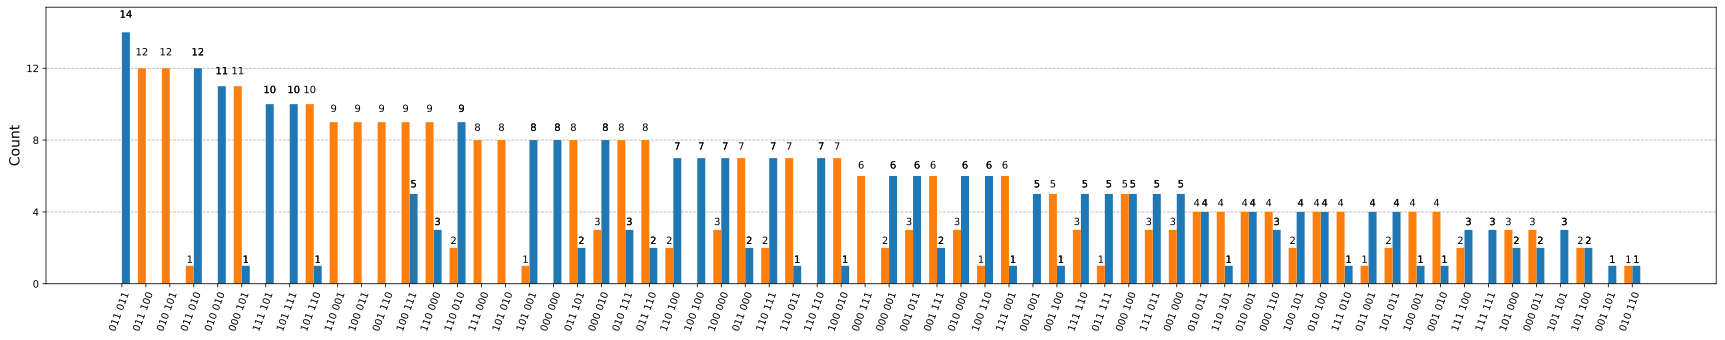

In [23]:
from qiskit.visualization import plot_histogram

even_counts = {k[2:]: v for k, v in counts.items() if k.startswith("0")}
odd_counts = {k[2:]: v for k, v in counts.items() if k.startswith("1")}

plot_histogram([even_counts, odd_counts], figsize=(30, 5), sort="value_desc")

### Process counts to amplitudes: Formate and Average

In [24]:
def stringify_state(state):
    """
    >>> stringify_state([[0, 0], [0, 1], [1, 1]])
    ['00', '01', '11']

    >>> stringify_state(4)
    ['00', '01', '10', '11']

    >>> stringify_state(8)
    ['000', '001', '010', '100', '011', '101', '110', '111']
    """
    if isinstance(state, int):
        n_data_qubits = int(log2(state))
        return sorted(
            [bin(i)[2:].zfill(n_data_qubits) for i in range(state)],
            key=lambda x: sum(int(i) for i in x),
        )
    return ["".join(map(str, s)) for s in state]

In [25]:
def formate_amplitudes(x, y, counts, lite):
    """Process counts average amplitudes"""
    nx = x if isinstance(x, int) else x.shape[0]
    ny = y if isinstance(y, int) else y.shape[0]

    ampl = np.zeros((nx, ny, 2))
    shots = sum(v for _, v in counts.items())
    noise_shots = 0

    xstates = {s: i for i, s in enumerate(stringify_state(x))}
    ystates = {s: i for i, s in enumerate(stringify_state(y))}
    astates = {"0": 0, "1": 1}

    for state, count in counts.items():
        astate, ystate, xstate = state.split()
        if lite:
            xstate = "".join(x.flatten().astype(str))

        if astate in astates and xstate in xstates and ystate in ystates:
            ampl[xstates[xstate], ystates[ystate], astates[astate]] = count

        else:
            noise_shots += count
            print(f"Excess state {state} with count {count}")

    if noise_shots:
        print(f"Noise shouts {noise_shots} form {shots}")

    # Averaging
    ampl /= shots - noise_shots
    ampl *= nx * ny
    np.clip(ampl, 0, 1, out=ampl)
    return ampl

In [26]:
def average_amplitudes(ampl):
    ampl = (ampl[:, :, 0] + (1 - ampl[:, :, 1])) / 2
    ampl = (ampl + ampl.T) / 2
    return ampl

In [27]:
x, y = 2**n_data_qubits, 2**n_data_qubits

In [28]:
ampl_formated = formate_amplitudes(x, y, counts, lite=False)

In [29]:
ampl_averaged = average_amplitudes(ampl_formated)

In [30]:
def heatmap(ax, mat, ylabels, xlabels, annotation=None, title=None, palette=None):
    if palette:
        ax.imshow(palette[mat], origin="lower", cmap="gray")

    else:
        ax.imshow(mat, origin="lower", cmap="gray")

    ax.set_xticks(range(0, len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=90, fontsize="20")
    ax.set_yticks(range(0, len(ylabels)))
    ax.set_yticklabels(ylabels, fontsize="20")
    if title:
        ax.set_title(title, fontsize="20")

    if annotation is not None:
        for i in range(annotation.shape[0]):
            for j in range(annotation.shape[1]):
                ax.text(j, i, annotation[i, j], ha="center", va="center", color="#FF0000", fontsize="20")

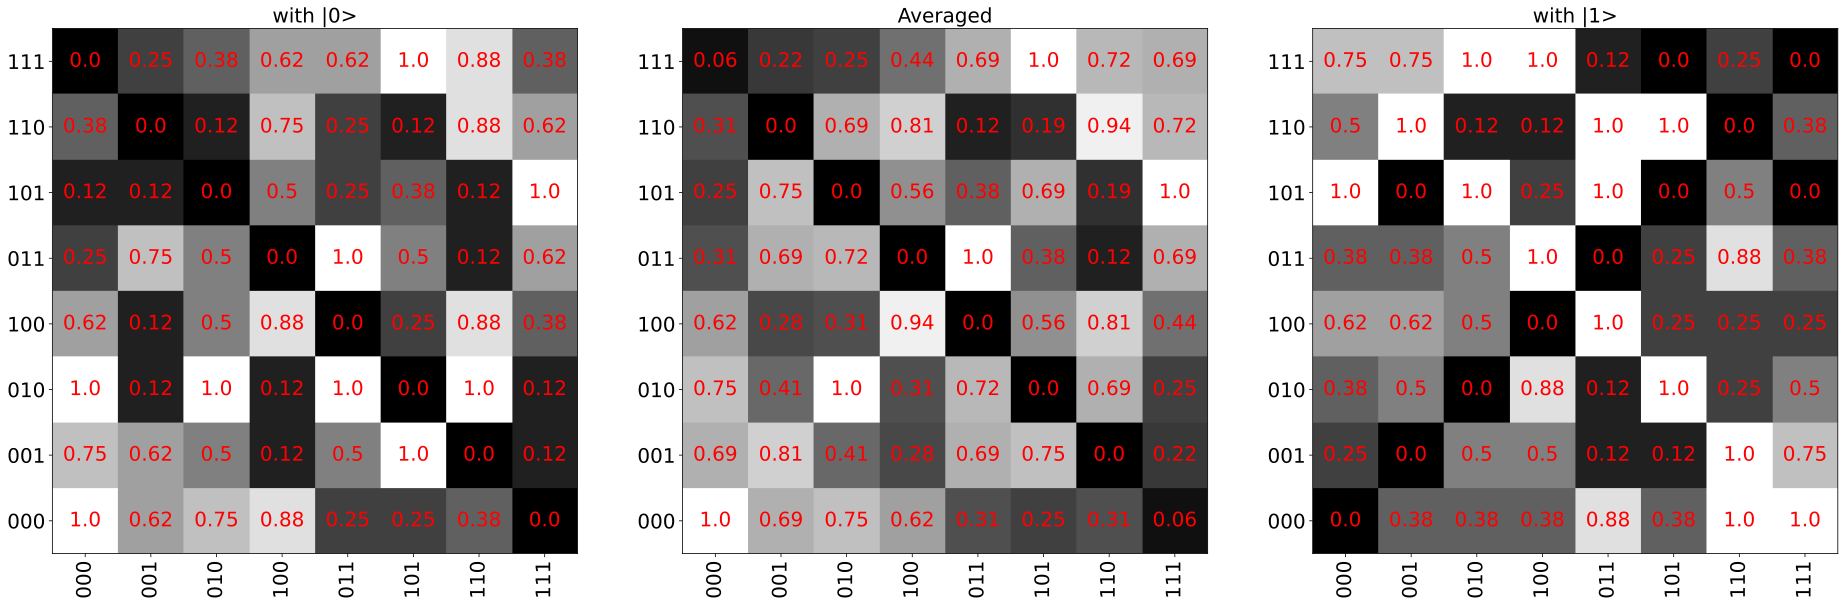

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(32, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(
    axes[0],
    ampl_formated[:, :, 0],
    xlabels,
    ylabels,
    annotation=ampl_formated[:, :, 0].round(2),
    title="with |0>",
)
heatmap(
    axes[1],
    ampl_averaged,
    xlabels,
    ylabels,
    annotation=ampl_averaged.round(2),
    title="Averaged",
)
heatmap(
    axes[2],
    ampl_formated[:, :, 1],
    xlabels,
    ylabels,
    annotation=ampl_formated[:, :, 1].round(2),
    title="with |1>",
)

### Extract Hamming distance

In [32]:
def extract_hamming_distance(x, y, ampl):
    n_data_qubits = min_qubits_for_data_encoding(x)
    return np.arccos(np.sqrt(ampl)) * 2 * n_data_qubits / pi

In [33]:
hdist = extract_hamming_distance(x, y, ampl_averaged)

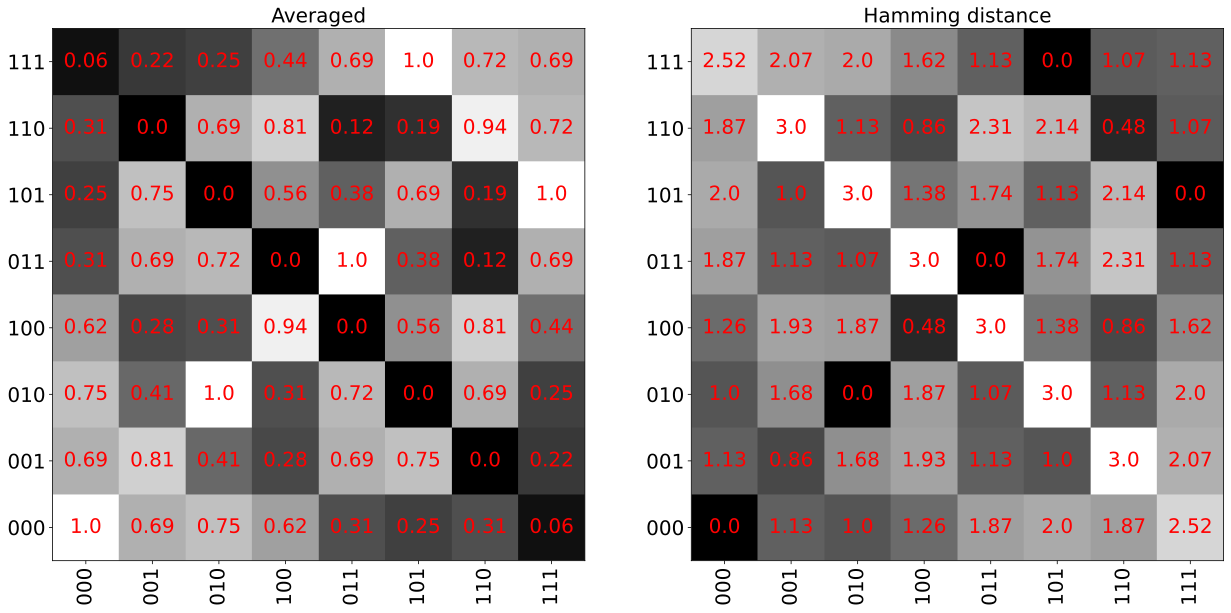

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(
    axes[0],
    ampl_averaged,
    xlabels,
    ylabels,
    annotation=ampl_averaged.round(2),
    title="Averaged",
)
heatmap(
    axes[1],
    hdist,
    xlabels,
    ylabels,
    annotation=hdist.round(2),
    title="Hamming distance",
)

### Fit limit and neighbors

In [35]:
from scipy.spatial import distance


def _arrify_state(state):
    if isinstance(state, np.ndarray):
        return state
    if isinstance(state, int):
        return np.array([list(map(int, s)) for s in stringify_state(state)])


def hdist_exact(x, y):
    x_arr = _arrify_state(x)
    y_arr = _arrify_state(y)
    hdist = distance.cdist(x_arr, y_arr, metric="hamming") * x_arr.shape[1]
    return hdist


def fit_neighbors(x, y, hdist, limit):
    neighbors = hdist < limit
    hdist_expected = hdist_exact(x, y)
    neighbors_expected = hdist_expected < limit
    x_arr = _arrify_state(x)
    y_arr = _arrify_state(y)
    errors = np.array([[" "] * x_arr.shape[0] for _ in range(y_arr.shape[0])])
    errors[(neighbors_expected != neighbors) & neighbors_expected] = "?"
    errors[(neighbors_expected != neighbors) & ~neighbors_expected] = "x"

    return neighbors, neighbors_expected, errors

In [36]:
def n_error(x, y, hdist, l):
    _, n, err = fit_neighbors(x, y, hdist, l)
    return (err != " ").sum() / 2

In [37]:
def fit_limit(x, y, hdist, neighbour, full=False, a_tol=None, ax=None):
    a_tol = a_tol or 1e-1
    limits_start, limits_end = neighbour + a_tol, neighbour + 1 - a_tol
    limits_steps = np.ceil((limits_end - limits_start) / a_tol).astype(int)

    limits = np.linspace(limits_start, limits_end, limits_steps)
    n_errors = [n_error(x, y, hdist, l) for l in limits]
    argmin_n_errors = np.argmin(n_errors)
    limit, error = limits[argmin_n_errors], n_errors[argmin_n_errors]
    if ax is not None:
        if full:
            limits_start, limits_end = 0, min_qubits_for_data_encoding(x)
            limits_steps = np.ceil((limits_end - limits_start) / a_tol).astype(int)
            limits = np.linspace(limits_start, limits_end, limits_steps)
            n_errors = [n_error(x, y, hdist, l) for l in limits]
        ax.plot(limits, n_errors)
        ax.plot([limit] * 2, (0, max(n_errors)))
        ax.set_xlabel("limit value")
        ax.set_ylabel("err")
        ax.grid()
    return limit, error

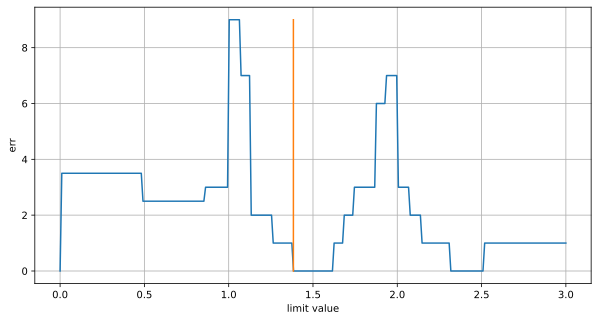

In [38]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit, error = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)

In [39]:
neighbors, neighbors_expected, errors = fit_neighbors(x, y, hdist, limit)

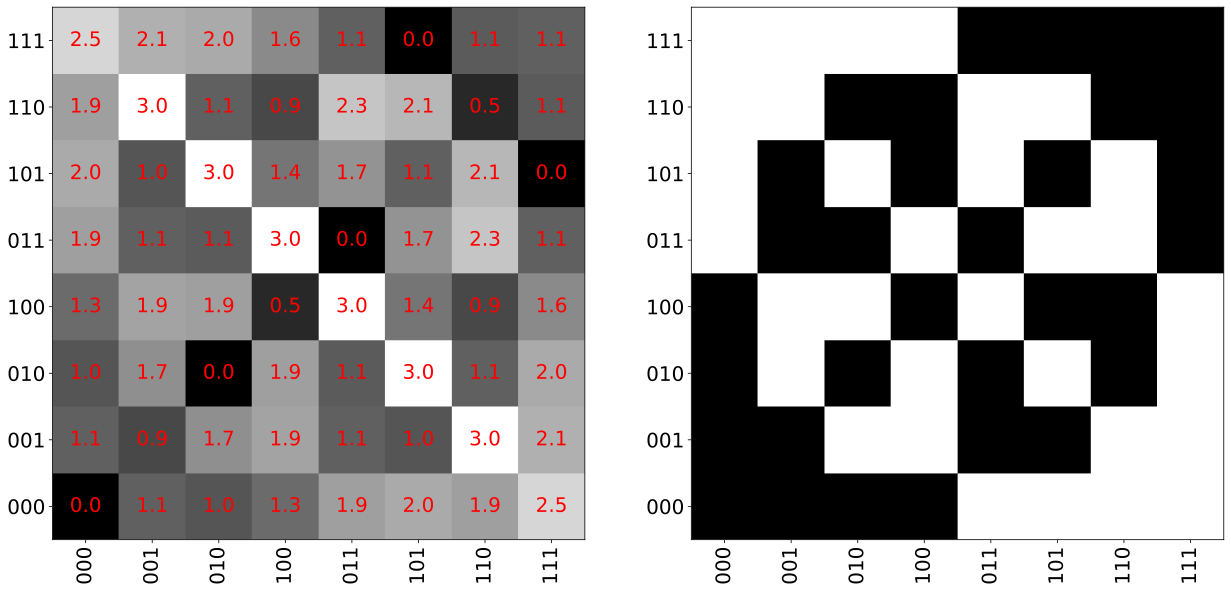

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(axes[0], hdist, xlabels, ylabels, annotation=hdist.round(1))
heatmap(axes[1], ~neighbors, xlabels, ylabels, annotation=errors)

## IBM backend

In [41]:
from qiskit_ibm_runtime import QiskitRuntimeService

%time service = QiskitRuntimeService()

CPU times: user 285 ms, sys: 46.2 ms, total: 332 ms
Wall time: 8.38 s


In [42]:
%time print(*(s.name for s in service.backends()), sep="\n")

ibm_brisbane
ibm_kyiv
ibm_sherbrooke
CPU times: user 203 ms, sys: 9.52 ms, total: 212 ms
Wall time: 6.2 s


In [43]:
ibm_backend = service.backend("ibm_sherbrooke")

### Transpiling

In [44]:
def transpile(circuit, backend, maps=None):
    cicruit_name = circuit.name
    if maps is None:
        from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

        pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
        circuit = pm.run(circuit)
        circuit.name = f"{cicruit_name}-auto_tanspiled"
        return circuit

    from collections import ChainMap

    layout = dict(ChainMap(*({r[i]: v for i, v in enumerate(map_)} for r, map_ in zip(circuit.qregs, maps))))
    import qiskit.compiler

    circuit = qiskit.compiler.transpile(circuit, backend, initial_layout=layout)
    circuit.name = f"{cicruit_name}-manual_tanspiled"
    return circuit

#### Example of auto transpiled circuit with 4 data qubits

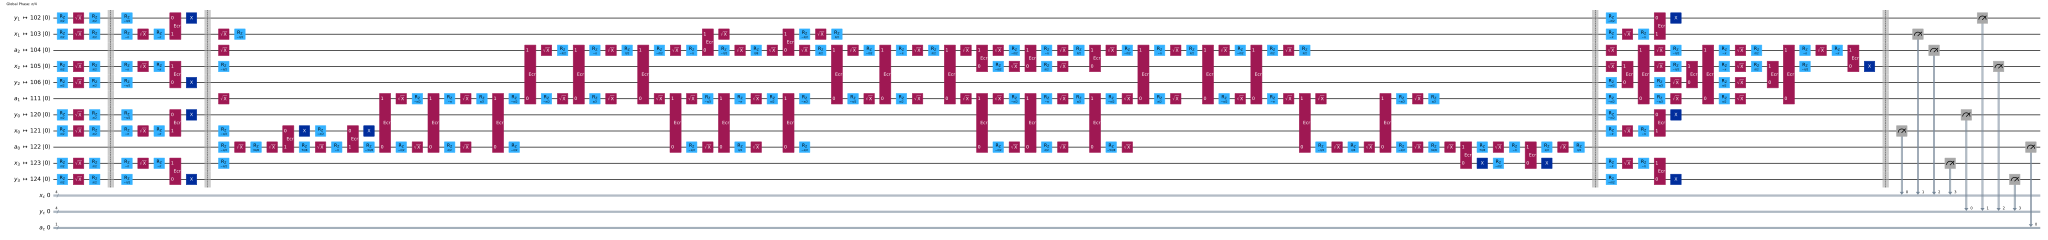

In [45]:
circuit = hamdist_full_tomography_circuit(4, 3).decompose(reps=5)
maps = [[121, 103, 105, 123], [120, 102, 106, 124], [122, 111, 104]]
circuit = transpile(circuit, ibm_backend, maps=maps)
circuit.draw(output="mpl", fold=-1, idle_wires=False, initial_state=True)

## Research of tomography on noise simulator

In [46]:
def hdist_tomography_from_result(result, x, y):
    counts = result.get_counts(0)
    ampl = formate_amplitudes(x, y, counts, lite=False)
    ampl = average_amplitudes(ampl)
    hdist = extract_hamming_distance(x, y, ampl)
    return hdist

In [47]:
%time noise_simulator = AerSimulator.from_backend(ibm_backend)

CPU times: user 1.53 s, sys: 20.4 ms, total: 1.55 s
Wall time: 1.44 s


### Example of tomography on noise simulator with auto transpiling and swaped ancilla

In [48]:
n_data_qubits, n_auxilia_qubits = 5, 5

In [49]:
shots = 120_000
shots

120000

In [50]:
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=5)

In [51]:
def qubit2index(q):
    return 10 * {"x": 0, "y": 1, "a": 2}[q._register.name] + q._index


def maps_from_flatten(maps_flatten):
    if len(maps_flatten) == 11:
        maps = [maps_flatten[:4], maps_flatten[4:8], maps_flatten[8:]]
    elif len(maps_flatten) == 15:
        maps = [maps_flatten[:5], maps_flatten[5:10], maps_flatten[10:]]
    else:
        raise ValueError(f"wrong length of maps: {len(maps_flatten)}")
    return maps


def maps_from_layout(layout):
    layout_dct = layout.final_virtual_layout().get_virtual_bits()
    maps_flatten = sorted([(qubit2index(q), v) for q, v in layout_dct.items()])
    maps_flatten = [i for _, i in maps_flatten]
    return maps_from_flatten(maps_flatten)


def maps2str(maps):
    return "||".join("|".join(str(i) for i in reg) for reg in maps)

In [52]:
def run_on_backend(backend, circuit, shots: int, maps=None, use_cached=True) -> qiskit.result.Result:
    assets_path = Path.cwd().parent / "assets"
    if not assets_path.exists():
        assets_path.mkdir()
    if not assets_path.is_dir():
        raise TypeError("is not a directory: {assets_path}")

    result_path_base = rf"result-{circuit.name}-{backend.name}-{shots}"
    maps_str = maps2str(maps) if maps is not None else None
    if use_cached is not False:
        cached_results = []
        path_pattern = re.compile(re.escape(result_path_base) + "-([\d|]+)-?([a-z\d]*).json")
        for result_path in assets_path.iterdir():
            m = path_pattern.match(result_path.name)
            if m is None:
                continue
            if maps is None or m.group(1) == maps_str:
                result = qiskit.result.Result.from_dict(json.loads(result_path.read_text()))
                print(f"Load result from '{os.path.relpath(result_path, Path.cwd())}'!")
                if use_cached is True or use_cached == "any":
                    return result
                elif use_cached == "all":
                    cached_results.append(result)
                else:
                    raise ValueError(f"wrong type of cache rule: {use_cached}")
        if len(cached_results) > 0:
            return cached_results

    circuit_transpiled = transpile(circuit, backend, maps=maps)
    if maps is None:
        maps = maps_from_layout(circuit_transpiled.layout)
    job = backend.run(circuit_transpiled, shots=shots)
    result = job.result()
    maps_str = maps2str(maps)
    if not isinstance(noise_simulator, AerSimulator):
        path = assets_path / f"{result_path_base}-{maps_str}-{job.job_id()}.json"
    else:
        path = assets_path / f"{result_path_base}-{maps_str}.json"
    path.write_text(json.dumps(result.to_dict(), default=lambda x: x.isoformat()))
    print(f"Result of shots={shots} saved on '{path.relative_to(Path.cwd())}'!")
    return result

In [53]:
%time result = run_on_backend(noise_simulator, circuit, 2**17)

Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-131072-87|93|102|103|104||105|106|107|108|111||120|121|122|123|124.json'!
CPU times: user 1.77 ms, sys: 1.51 ms, total: 3.28 ms
Wall time: 3.73 ms


In [54]:
x, y = 2**n_data_qubits, 2**n_data_qubits
%time hdist = hdist_tomography_from_result(result, x, y)

CPU times: user 4.77 ms, sys: 533 µs, total: 5.31 ms
Wall time: 4.98 ms


1.7576288659793815 0.0
2.3899999999999997 0.0


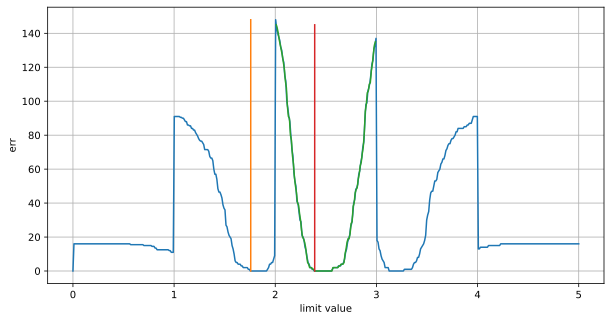

In [55]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit, error = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)
print(limit, error)
limit, error = fit_limit(x, y, hdist, 2, full=False, a_tol=1e-2, ax=ax)
print(limit, error)
ax.grid()

## Research min number of shots

Для того, чтобы расстояния была различимы, необходимо, чтобы на амплитуды двух отличных расстояний различались по высоте хотябы на один пункт. В идеальном случае расстояния в один бит, могут быть представлены только одним пунктом.
Таким образом минимально возможное количество прогонов определяется суммой всех расстояний. 

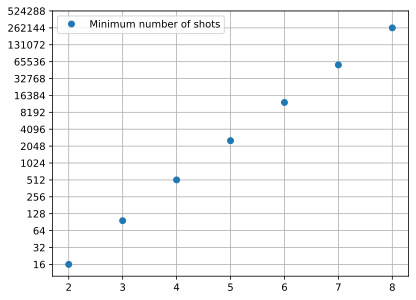

In [56]:
_, ax = plt.subplots(1, 1)
data_qubits_span = list(range(2, 9))
min_shots_span = [hdist_exact(2**i, 2**i).sum() for i in data_qubits_span]
ax.plot(data_qubits_span, min_shots_span, "o", label="Minimum number of shots")
ax.set_yscale("log", base=2)
ax.set_yticks([2**i for i in range(4, 20)])
ax.set_yticklabels([2**i for i in range(4, 20)])
ax.legend()
ax.grid()

In [57]:
np.log2(min_shots_span)[1:] - np.log2(min_shots_span)[:-1]

array([2.5849625 , 2.4150375 , 2.32192809, 2.26303441, 2.22239242,
       2.19264508])

## Reserch optimal number of shots

In [58]:
def neighbors_errors_from_result(result, n_data_qubits):
    x, y = 2**n_data_qubits, 2**n_data_qubits
    hdist = hdist_tomography_from_result(result, x, y)
    errs = [fit_limit(x, y, hdist, neighbour=n, a_tol=1e-3) for n in range(1, n_data_qubits // 2 + 1)]
    return errs


def argminmeans(lst):
    return np.argmin([np.mean([e for _, e in item]) for item in lst])


def neighbors_errors(backend, circuit, n_data_qubits, shots, maps=None, use_cached=True, choose=None):
    result = run_on_backend(backend, circuit, shots, maps=maps, use_cached=use_cached)
    if not isinstance(result, (tuple, list)):
        return neighbors_errors_from_result(result, n_data_qubits)

    choose = argminmeans if choose is None else choose
    errss = [neighbors_errors_from_result(r, n_data_qubits) for r in result]
    print(errss)
    errs_indx = choose(errss)
    print(f"Choose {errs_indx} result.")
    return errss[errs_indx]


def neighbors_errors_over_shots(
    backend, circuit, n_data_qubits, shots_arr, maps=None, use_cached=True, choose=None
) -> list:
    errs = [
        neighbors_errors(backend, circuit, n_data_qubits, s, maps=maps, choose=choose, use_cached=use_cached)
        for s in shots_arr
    ]
    errs = [list(zip(*limits_and_errors)) for limits_and_errors in list(zip(*errs))]
    return errs

In [59]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def line(x, a, b):
    return a * x + b


def fit_exp(shots_arr, errs_arr):
    errs_arr_argmin = np.argmin(np.hstack((errs_arr, [0])))  # can not fit at zero
    errs_arr_up_to_min, shots_arr_ = errs_arr[:errs_arr_argmin], shots_arr[:errs_arr_argmin]
    params, params_covariance = curve_fit(line, shots_arr_, np.log(errs_arr_up_to_min), p0=(1e-3, 1))
    r2 = r2_score(errs_arr_up_to_min, np.exp(line(shots_arr_, *params)))
    return params, r2

### 4 data qubits

In [60]:
n_data_qubits, n_auxilia_qubits = 4, 3
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=5)

In [61]:
shots_arr = np.linspace(500, 1.7e4, 34).astype(int)  # ; shots_arr

In [62]:
# maps = None
# maps = [[99, 101, 117, 119], [98, 102, 116, 120], [100, 110, 118]]
maps = [[121, 103, 105, 123], [120, 102, 106, 124], [122, 111, 104]]
limits_and_errors = neighbors_errors_over_shots(noise_simulator, circuit, n_data_qubits, shots_arr, maps=maps)

Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-aer_simulator_from(ibm_sherbrooke)-500-121|103|105|123||120|102|106|124||122|111|104.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-aer_simulator_from(ibm_sherbrooke)-1000-121|103|105|123||120|102|106|124||122|111|104.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-aer_simulator_from(ibm_sherbrooke)-1500-121|103|105|123||120|102|106|124||122|111|104.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-aer_simulator_from(ibm_sherbrooke)-2000-121|103|105|123||120|102|106|124||122|111|104.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-aer_simulator_from(ibm_sherbrooke)-2500-121|103|105|123||120|102|106|124||122|111|104.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-aer_simulator_from(ibm_sherbrooke)-3000-121|103|105|123||120|102|106|124||122|111|104.json'!
Load result from '../as

In [63]:
import re

pattern = rf"result-{circuit.name}-{ibm_backend.name}-(\d+)-.*.json"
ibm_shots_arr = sorted(
    {
        int(m.group(1))
        for item in (Path.cwd().parent / "assets").iterdir()
        if (m := re.match(pattern, str(item.name)))
    }
)  # ibm_shots_arr = np.linspace(2e3, 1.7e4, 16).astype(int)
ibm_shots_arr

[2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 8192,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000]

In [64]:
ibm_limits_and_errors = neighbors_errors_over_shots(
    ibm_backend, circuit, n_data_qubits, ibm_shots_arr, use_cached="all"
)

Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-2000-121|103|104|123||120|102|105|124||106|111|122-cwkhzh6mptp00085zwd0.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-2000-46|35|55|50||45|28|68|51||47|48|49-cwjtvw731we000888jf0.json'!
[[(1.351, 34.0), (2.082, 26.0)], [(1.702, 9.0), (2.4859999999999998, 12.0)]]
Choose 1 result.
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-3000-46|35|55|50||45|28|68|51||47|48|49-cwk4qje9r49g00899ddg.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-3000-121|103|104|123||120|102|105|124||106|111|122-cwkq6zv31we00088brxg.json'!
[[(1.687, 9.0), (2.387, 13.0)], [(1.001, 38.0), (2.219, 40.0)]]
Choose 0 result.
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-4000-121|103|104|123||120|102|105|124||106|111|122-cwkq7zf9r49g0089b7sg.json'!
Load result from '../assets

/var/folders/tf/45m56ndn4qxc63cljwjkk7_w0000gn/T/ipykernel_71906/1436220519.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


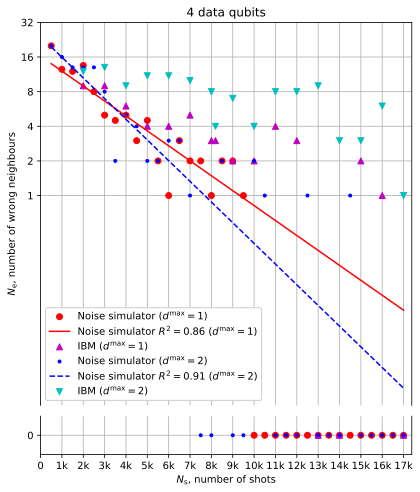

In [65]:
fig, (axy, axx) = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={"height_ratios": [10, 1]})
ibm_errs_arrs = list(zip(*ibm_limits_and_errors))[1]
for i, errs_arr in enumerate(list(zip(*limits_and_errors))[1], 1):
    color = ("r", "b")[i - 1]
    marker = ("o", ".")[i - 1]
    axy.scatter(
        shots_arr, errs_arr, marker=marker, c=color, label=rf"Noise simulator ($d^\mathrm{{max}} = {i}$)"
    )
    axx.scatter(shots_arr, errs_arr, marker=marker, c=color)

    params, r2 = fit_exp(shots_arr, errs_arr)
    linestyle = ("-", "--")[i - 1]
    axy.plot(
        shots_arr,
        np.exp(line(shots_arr, *params)),
        f"{linestyle}{color}",
        label=rf"Noise simulator $R^2={r2:.2}$ ($d^\mathrm{{max}} = {i}$)",
    )

    ibm_marker = ("^", "v")[i - 1]
    ibm_color = ("m", "c")[i - 1]
    ibm_shots_arr_, ibm_errs_arr_ = np.array(ibm_shots_arr), np.array(ibm_errs_arrs[i - 1])
    ibm_shots_arr_, ibm_errs_arr_ = ibm_shots_arr_, ibm_errs_arr_
    axy.scatter(
        ibm_shots_arr_,
        ibm_errs_arr_,
        marker=ibm_marker,
        c=ibm_color,
        label=rf"IBM ($d^\mathrm{{max}} = {i}$)",
    )
    axx.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color)


axy.set_ylabel(r"$N_\mathrm{e}$, number of wrong neighbours")
axy.set_yscale("log", base=2)
# ax.set_yticks([2**i / 2 ** (2 * n_data_qubits) for i in range(1, 8)])
axy.set_yticks([2**i for i in range(6)], [2**i for i in range(6)])

axx.set_yticks([0])
axx.set_yticklabels([0])
axx.set_ylim(-0.5, 0.5)

axy.spines["bottom"].set_visible(False)
axy.set_xticks(np.linspace(0, 20e3, 21))
axy.set_xticklabels([])
axy.tick_params(axis="x", width=0)
axy.set_xlim(0, 2**14 + 1e3)

axx.spines["top"].set_visible(False)
axx.set_xlabel("$N_\mathrm{s}$, number of shots")
axx.set_xticks(np.linspace(0, 20e3, 21))
axx.set_xticklabels([0] + [f"{i}k" for i in np.linspace(1, 20, 20).astype(int)])
axx.set_xlim(0, 2**14 + 1e3)

axy.grid()
axy.set_axisbelow(True)
axy.legend(loc="lower left", framealpha=1)
# axy.legend(loc="upper right")
axy.set_title(f"{n_data_qubits} data qubits")
axx.grid()
axx.set_axisbelow(True)


fig.tight_layout()
fig.savefig(f"./ne-over-shots-n{n_data_qubits}.pdf")
fig.show()

In [66]:
ERRORS_OVER_SHOTS = {
    "IBM": {
        "4": (ibm_shots_arr, ibm_limits_and_errors),
    },
    "NOISE": {
        "4": (shots_arr, limits_and_errors),
    },
}

### 5 data qubits

In [67]:
n_data_qubits, n_auxilia_qubits = 5, 5
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=5)

In [68]:
shots_arr = np.hstack(
    (
        np.linspace(2**13, 2**14, 11).astype(int),
        np.linspace(2**14, 2**15, 11).astype(int),
        np.linspace(2**15, 2**16, 21).astype(int),
        np.linspace(2**16, 2**17, 11).astype(int),
    )
)

In [69]:
maps = None
# maps = [[109, 95, 91, 101, 110], [114, 94, 79, 102, 118], [96, 97, 98, 99, 100]]
# maps = [[123, 121, 103, 93, 107], [124, 120, 102, 87, 108], [122, 111, 104, 105, 106]]
# maps = [[46, 35, 50, 69, 67], [45, 28, 51, 70, 66], [47, 48, 49, 55, 68]]
limits_and_errors = neighbors_errors_over_shots(noise_simulator, circuit, n_data_qubits, shots_arr)

Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-8192-87|93|102|103|104||105|106|107|108|111||120|121|122|123|124.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-9011-87|93|102|103|104||105|106|107|108|111||120|121|122|123|124.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-9830-87|93|102|103|104||105|106|107|108|111||120|121|122|123|124.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-10649-87|93|102|103|104||105|106|107|108|111||120|121|122|123|124.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-11468-87|93|102|103|104||105|106|107|108|111||120|121|122|123|124.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-aer_simulator_from(ibm_sherbrooke)-12288-87

In [70]:
import re

pattern = rf"result-{circuit.name}-{ibm_backend.name}-(\d+)-.*.json"
ibm_shots_arr = sorted(
    {
        int(m.group(1))
        for item in (Path.cwd().parent / "assets").iterdir()
        if (m := re.match(pattern, str(item.name)))
    }
)
# ibm_shots_arr = np.linspace(2e3, 1.7e4, 16).astype(int)
print(ibm_shots_arr)

[4096, 8192, 16384, 32768, 45000, 55000, 65536, 80000, 90000, 100000, 131072, 200000, 220000, 240000, 262144]


In [71]:
ibm_limits_and_errors = neighbors_errors_over_shots(ibm_backend, circuit, n_data_qubits, ibm_shots_arr)

Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-4096-123|121|103|93|107||124|120|102|87|108||122|111|104|105|106-cwg5q3m543p000865a50.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-8192-123|121|103|93|107||124|120|102|87|108||122|111|104|105|106-cwg5pfs543p000865a1g.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-16384-123|121|103|93|107||124|120|102|87|108||122|111|104|105|106-cwg5nx70r6b0008peb4g.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-32768-109|95|91|101|110||114|94|79|102|118||96|97|98|99|100-cw89q5w9ezk00080zv70.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-45000-123|121|103|93|107||124|120|102|87|108||122|111|104|105|106-cwjf1an40e00008928jg.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-55000-123|121|103|93|107||12

15 15
15 15


/var/folders/tf/45m56ndn4qxc63cljwjkk7_w0000gn/T/ipykernel_71906/4153337755.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


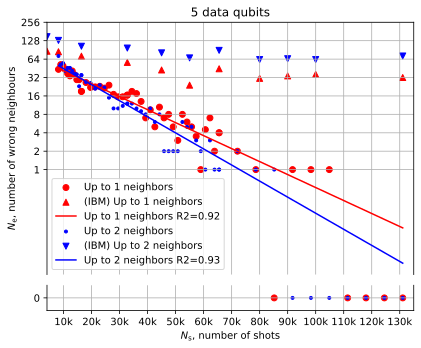

In [72]:
fig, (axy, axx) = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={"height_ratios": [10, 1]})
ibm_errs_arrs = list(zip(*ibm_limits_and_errors))[1]
for i, errs_arr in enumerate(list(zip(*limits_and_errors))[1], 1):
    color = ("r", "b")[i - 1]
    marker = ("o", ".")[i - 1]
    axy.scatter(shots_arr, errs_arr, marker=marker, c=color, label=f"Up to {i} neighbors")
    axx.scatter(shots_arr, errs_arr, marker=marker, c=color)

    ibm_marker = ("^", "v")[i - 1]
    print(len(ibm_shots_arr), len(ibm_errs_arrs[i - 1]))
    axy.scatter(
        ibm_shots_arr, ibm_errs_arrs[i - 1], marker=ibm_marker, c=color, label=f"(IBM) Up to {i} neighbors"
    )
    axx.scatter(ibm_shots_arr, ibm_errs_arrs[i - 1], marker=ibm_marker, c=color)

    params, r2 = fit_exp(shots_arr, errs_arr)
    axy.plot(
        shots_arr,
        np.exp(line(shots_arr, *params)),
        f"{color}",
        label=f"Up to {i} neighbors R2={r2:.2}",
    )


axy.set_ylabel(r"$N_\mathrm{e}$, number of wrong neighbours")
axy.set_yscale("log", base=2)
# ax.set_yticks([2**i / 2 ** (2 * n_data_qubits) for i in range(1, 8)])
axy.set_yticks([2**i for i in range(9)], [2**i for i in range(9)])

axx.set_yticks([0])
axx.set_yticklabels([0])
axx.set_ylim(-0.5, 0.5)

axy.spines["bottom"].set_visible(False)
axy.set_xticks(np.linspace(1e4, 13e4, 13))
axy.set_xticklabels([])
axy.tick_params(axis="x", width=0)
axy.set_xlim(2**12, 13e4 + 5e3)

axx.spines["top"].set_visible(False)
axx.set_xlabel("$N_\mathrm{s}$, number of shots")
axx.set_xticks(np.linspace(1e4, 13e4, 13))
axx.set_xticklabels([f"{i}0k" for i in np.linspace(1, 13, 13).astype(int)])
axx.set_xlim(2**12, 13e4 + 5e3)

axy.grid()
axy.legend(loc="lower left")
axy.set_title(f"{min_qubits_for_data_encoding(x)} data qubits")
axx.grid()


fig.tight_layout()
fig.savefig(f"./ne-over-shots-n{n_data_qubits}.pdf")
fig.show()

In [73]:
ERRORS_OVER_SHOTS["IBM"]["5"] = (ibm_shots_arr, ibm_limits_and_errors)
ERRORS_OVER_SHOTS["NOISE"]["5"] = (shots_arr, limits_and_errors)

### Figure for paper

/var/folders/tf/45m56ndn4qxc63cljwjkk7_w0000gn/T/ipykernel_71906/3092384781.py:55: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axy.set_ylim(0, 32)
/var/folders/tf/45m56ndn4qxc63cljwjkk7_w0000gn/T/ipykernel_71906/3092384781.py:124: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axy.set_ylim(0, 128)


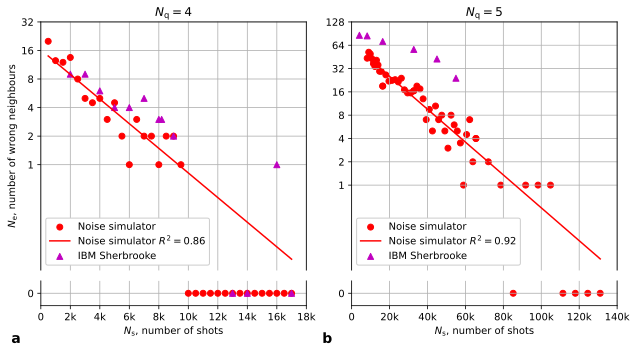

In [74]:
(shots_arr, limits_and_errors) = ERRORS_OVER_SHOTS["NOISE"]["4"]
(ibm_shots_arr, ibm_limits_and_errors) = ERRORS_OVER_SHOTS["IBM"]["4"]

fig, ((axy, axy_), (axx, axx_)) = plt.subplots(2, 2, figsize=(9, 5), gridspec_kw={"height_ratios": [10, 1]})
ibm_errs_arrs = list(zip(*ibm_limits_and_errors))[1]
for i, errs_arr in enumerate(list(zip(*limits_and_errors))[1], 1):
    color = ("r", "b")[i - 1]
    marker = ("o", ".")[i - 1]
    axy.scatter(shots_arr, errs_arr, marker=marker, c=color, label=rf"Noise simulator")
    # axy.scatter(shots_arr, errs_arr, marker=marker, c=color, label=rf"Noise simulator ($d^\mathrm{{max}} = {i}$)")
    axx.scatter(shots_arr, errs_arr, marker=marker, c=color)

    params, r2 = fit_exp(shots_arr, errs_arr)
    linestyle = ("-", "--")[i - 1]
    axy.plot(
        shots_arr,
        np.exp(line(shots_arr, *params)),
        f"{linestyle}{color}",
        # label=rf"Noise simulator $R^2={r2:.2}$ ($d^\mathrm{{max}} = {i}$)",
        label=rf"Noise simulator $R^2={r2:.2}$",
    )

    ibm_marker = ("^", "v")[i - 1]
    ibm_color = ("m", "c")[i - 1]
    ibm_shots_arr_, ibm_errs_arr_ = np.array(ibm_shots_arr), np.array(ibm_errs_arrs[i - 1])
    ibm_shots_ok = np.logical_or(ibm_shots_arr_ < 1e4, ibm_errs_arr_ < 2)
    ibm_shots_arr_, ibm_errs_arr_ = ibm_shots_arr_[ibm_shots_ok], ibm_errs_arr_[ibm_shots_ok]
    # axy.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color, label=rf"IBM ($d^\mathrm{{max}} = {i}$)")
    axy.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color, label=rf"IBM Sherbrooke")
    axx.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color)

    break

axy.set_ylabel(r"$N_\mathrm{e}$, number of wrong neighbours")
axy.set_yscale("log", base=2)
# ax.set_yticks([2**i / 2 ** (2 * n_data_qubits) for i in range(1, 8)])
axy.set_yticks([2**i for i in range(6)], [2**i for i in range(6)])

axx.set_yticks([0])
axx.set_yticklabels([0])
axx.set_ylim(-0.5, 0.5)

axy.spines["bottom"].set_visible(False)
axy.set_xticks(np.linspace(0, 18e3, 10))
axy.set_xticklabels([])
axy.tick_params(axis="x", width=0)
axy.set_xlim(0, 18e3)

axx.spines["top"].set_visible(False)
axx.set_xlabel("$N_\mathrm{s}$, number of shots")
axx.set_xticks(np.linspace(0, 18e3, 10))
axx.set_xticklabels([0 if i == 0 else f"{i}k" for i in np.linspace(0, 18, 10).astype(int)])
axx.set_xlim(0, 18e3)

axy.set_ylim(0, 32)
axy.grid()
axy.set_axisbelow(True)
axy.legend(loc="lower left", framealpha=1)
# axy.legend(loc="upper right")
axy.set_title(r"$N_\mathrm{{q}} = 4$")
# axy.set_title(f"{n_data_qubits} data qubits")
axx.grid()
axx.set_axisbelow(True)


axx.text(-2000, -2, "a", color="k", fontsize="14", fontweight="bold")


(shots_arr, limits_and_errors) = ERRORS_OVER_SHOTS["NOISE"]["5"]
(ibm_shots_arr, ibm_limits_and_errors) = ERRORS_OVER_SHOTS["IBM"]["5"]

axy, axx = axy_, axx_

ibm_errs_arrs = list(zip(*ibm_limits_and_errors))[1]
for i, errs_arr in enumerate(list(zip(*limits_and_errors))[1], 1):
    color = ("r", "b")[i - 1]
    marker = ("o", ".")[i - 1]
    axy.scatter(shots_arr, errs_arr, marker=marker, c=color, label=rf"Noise simulator")
    # axy.scatter(shots_arr, errs_arr, marker=marker, c=color, label=rf"Noise simulator ($d^\mathrm{{max}} = {i}$)")
    axx.scatter(shots_arr, errs_arr, marker=marker, c=color)

    params, r2 = fit_exp(shots_arr, errs_arr)
    linestyle = ("-", "--")[i - 1]
    axy.plot(
        shots_arr,
        np.exp(line(shots_arr, *params)),
        f"{linestyle}{color}",
        # label=rf"Noise simulator $R^2={r2:.2}$ ($d^\mathrm{{max}} = {i}$)",
        label=rf"Noise simulator $R^2={r2:.2}$",
    )

    ibm_marker = ("^", "v")[i - 1]
    ibm_color = ("m", "c")[i - 1]
    ibm_shots_arr_, ibm_errs_arr_ = np.array(ibm_shots_arr), np.array(ibm_errs_arrs[i - 1])
    ibm_shots_ok = ibm_shots_arr_ < 6e4
    ibm_shots_arr_, ibm_errs_arr_ = ibm_shots_arr_[ibm_shots_ok], ibm_errs_arr_[ibm_shots_ok]
    # axy.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color, label=rf"IBM ($d^\mathrm{{max}} = {i}$)")
    axy.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color, label=rf"IBM Sherbrooke")
    axx.scatter(ibm_shots_arr_, ibm_errs_arr_, marker=ibm_marker, c=ibm_color)

    break

# axy.set_ylabel(r"$N_\mathrm{e}$, number of wrong neighbours")
axy.set_yscale("log", base=2)
# ax.set_yticks([2**i / 2 ** (2 * n_data_qubits) for i in range(1, 8)])
axy.set_yticks([2**i for i in range(9)], [2**i for i in range(9)])

axx.set_yticks([0])
axx.set_yticklabels([0])
axx.set_ylim(-0.5, 0.5)

axy.spines["bottom"].set_visible(False)
axy.set_xticks(np.linspace(0, 14e4, 8))
axy.set_xticklabels([])
axy.tick_params(axis="x", width=0)
axy.set_xlim(0, 14e4)

axx.spines["top"].set_visible(False)
axx.set_xlabel("$N_\mathrm{s}$, number of shots")
axx.set_xticks(np.linspace(0, 14e4, 8))
axx.set_xticklabels([0 if i == 0 else f"{i}0k" for i in np.linspace(0, 14, 8).astype(int)])
axx.set_xlim(0, 14e4)

axy.set_ylim(0, 128)
axy.grid()
axy.legend(loc="lower left", framealpha=1)
axy.set_title(r"$N_\mathrm{{q}} = 5$")
# axy.set_title(f"{min_qubits_for_data_encoding(x)} data qubits")
axx.grid()

axx.text(-15500, -2, "b", color="k", fontsize="14", fontweight="bold")


fig.tight_layout()
fig.savefig(f"./ne-over-shots-n4-n5.eps")
fig.savefig(f"./ne-over-shots-n4-n5.pdf")
fig.savefig(f"./ne-over-shots-n4-n5.png")

## Tomography on IBMQ 

### 4 data qubits with manual transpiling and ancillas swapping 

In [75]:
n_data_qubits, n_auxilia_qubits = 4, 3

In [76]:
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=5)

In [77]:
shots = 2**13
shots

8192

In [78]:
# maps = [[99, 101, 117, 119], [98, 102, 116, 120], [100, 110, 118]]
# maps = [[121, 103, 105, 123], [120, 102, 106, 124], [122, 111, 104]]

# 99|101|117|119||98|102|116|120||100|110|118-cw89p5r9ezk00080zv40

results = run_on_backend(ibm_backend, circuit, shots=shots, use_cached="all")  # "cw89p5r9ezk00080zv40"

Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-8192-99|101|117|119||98|102|116|120||100|110|118-cw89p5r9ezk00080zv40.json'!
Load result from '../assets/result-hd_full_tomography-circuit-nd4-na3-ibm_sherbrooke-8192-121|103|104|123||120|102|105|124||106|111|122-cwkqbvq40e0000898hhg.json'!


In [79]:
neighbors_errors_from_result(results[0], n_data_qubits)

[(1.699, 3.0), (2.426, 4.0)]

In [80]:
x, y = 2**n_data_qubits, 2**n_data_qubits
hdist = hdist_tomography_from_result(results[0], x, y)

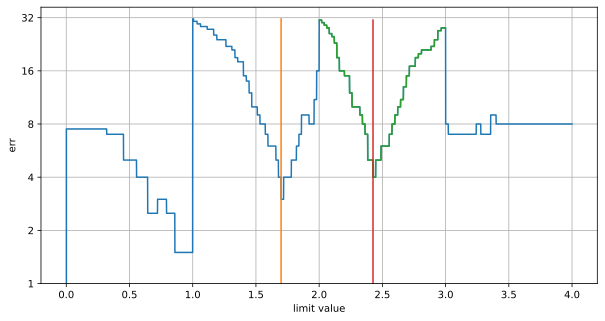

In [81]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_yscale("log", base=2)
limit1, error1 = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-3, ax=ax)
limit2, error2 = fit_limit(x, y, hdist, 2, full=False, a_tol=1e-3, ax=ax)
ax.set_yticks([2**i for i in range(6)], labels=[2**i for i in range(6)])
ax.grid();

In [82]:
print(limit1, error1)
print(limit2, error2)

1.699 3.0
2.426 4.0


In [83]:
neighbors, neighbors_expected, errors = fit_neighbors(x, y, hdist, limit1)

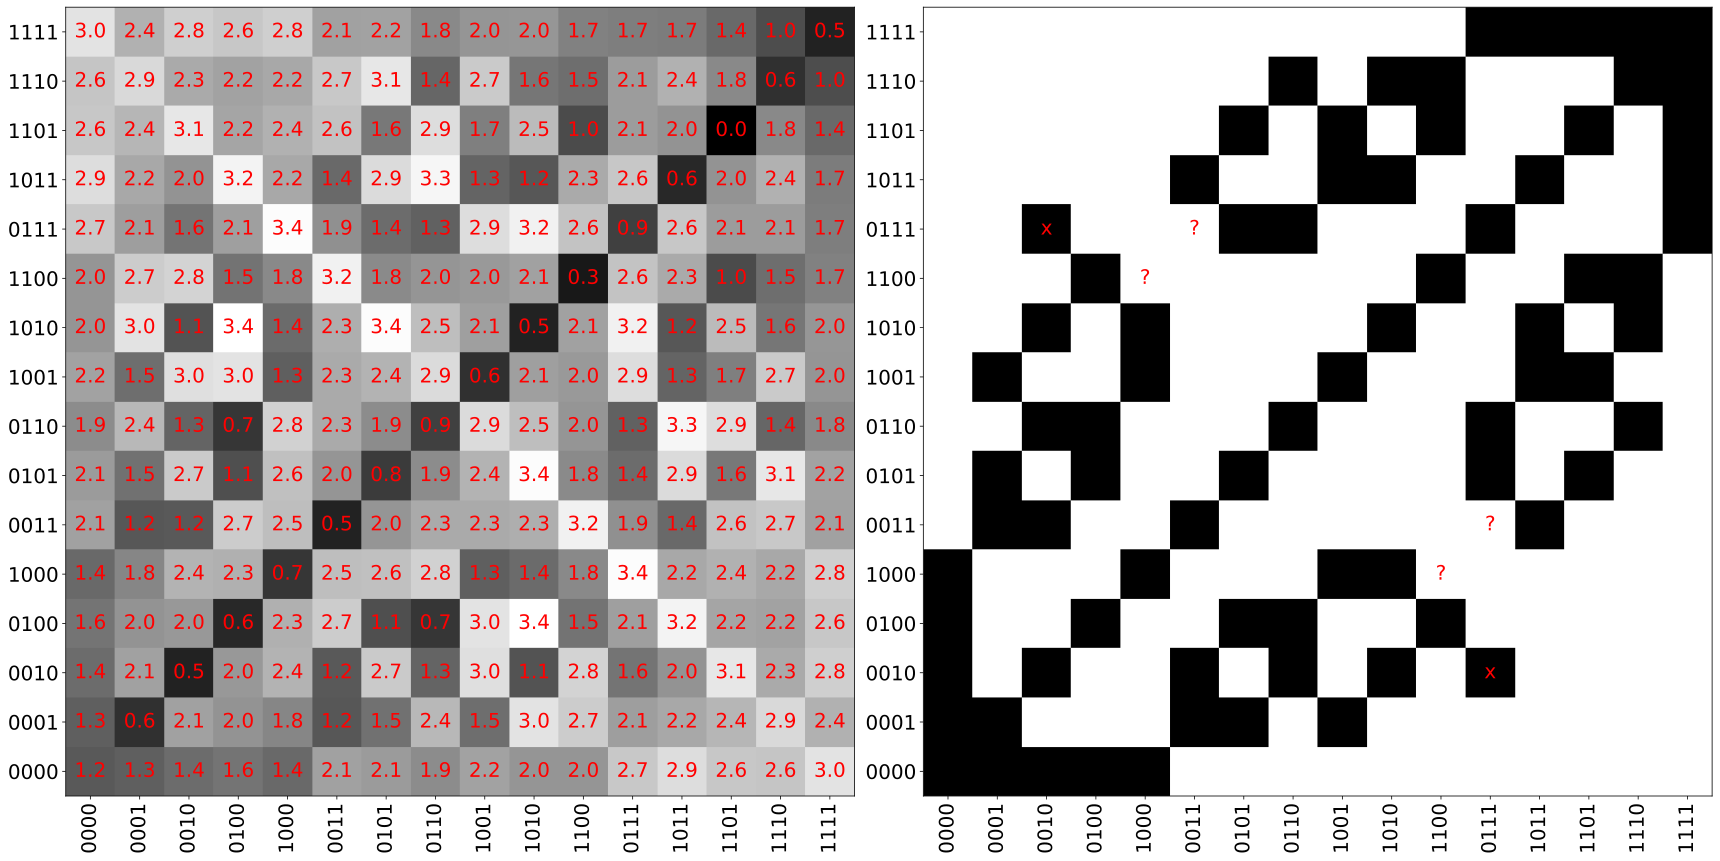

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(axes[0], hdist, xlabels, ylabels, annotation=hdist.round(1))
heatmap(axes[1], ~neighbors, xlabels, ylabels, annotation=errors)
fig.tight_layout()

#### Figure of tomography result for paper

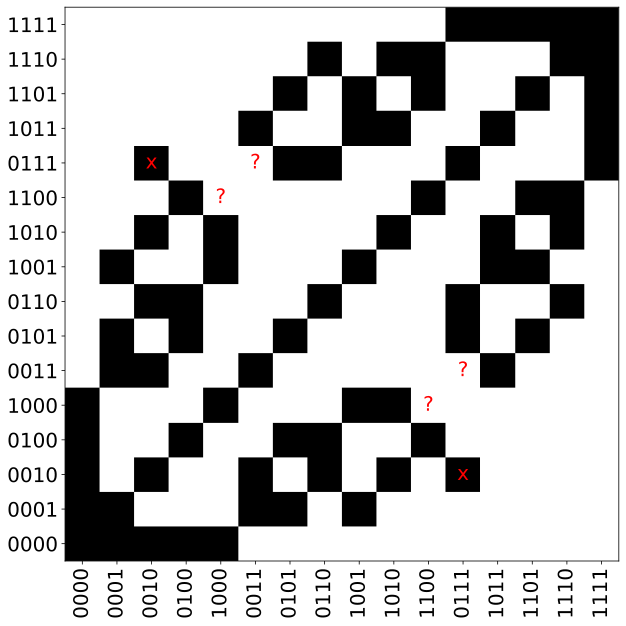

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xlabels, ylabels = stringify_state(x), stringify_state(y)
heatmap(ax, ~neighbors, xlabels, ylabels, annotation=errors)
fig.savefig(f"hd_tomography_n{n_data_qubits}.eps", bbox_inches="tight")
fig.savefig(f"hd_tomography_n{n_data_qubits}.pdf", bbox_inches="tight")
fig.savefig(f"hd_tomography_n{n_data_qubits}.png", bbox_inches="tight")

### 5 data qubits with manual transpiling and ancillas swapping 

In [86]:
n_data_qubits, n_auxilia_qubits = 5, 5

In [87]:
circuit = hamdist_full_tomography_circuit(n_data_qubits, n_auxilia_qubits).decompose(reps=5)

In [88]:
shots = 2**18
shots

262144

In [89]:
# maps = [[109, 95, 91, 101, 110], [114, 94, 79, 102, 118], [96, 97, 98, 99, 100]]
# maps = [[123, 121, 103, 93, 107], [124, 120, 102, 87, 108], [122, 111, 104, 105, 106]]
# maps = [[46, 35, 50, 69, 67], [45, 28, 51, 70, 66], [47, 48, 49, 55, 68]]
results = run_on_backend(ibm_backend, circuit, shots=shots, use_cached="all")  # cxe6nf5ky7rg0083pew0

Load result from '../assets/result-hd_full_tomography-circuit-nd5-na5-ibm_sherbrooke-262144-123|121|103|93|107||124|120|102|87|108||122|111|104|105|106-cwhy0vb9r49g0085r9rg.json'!


In [90]:
x, y = 2**n_data_qubits, 2**n_data_qubits
hdist = hdist_tomography_from_result(results[0], x, y)

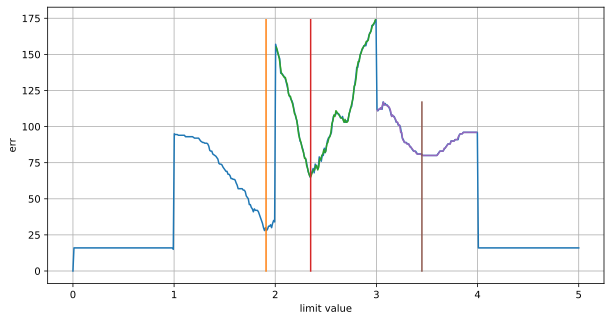

In [91]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

limit1, error1 = fit_limit(x, y, hdist, 1, full=True, a_tol=1e-2, ax=ax)
limit2, error2 = fit_limit(x, y, hdist, 2, full=False, a_tol=1e-2, ax=ax)
limit3, error3 = fit_limit(x, y, hdist, 3, full=False, a_tol=1e-2, ax=ax)

In [92]:
neighbors, neighbors_expected, errors = fit_neighbors(x, y, hdist, limit2)

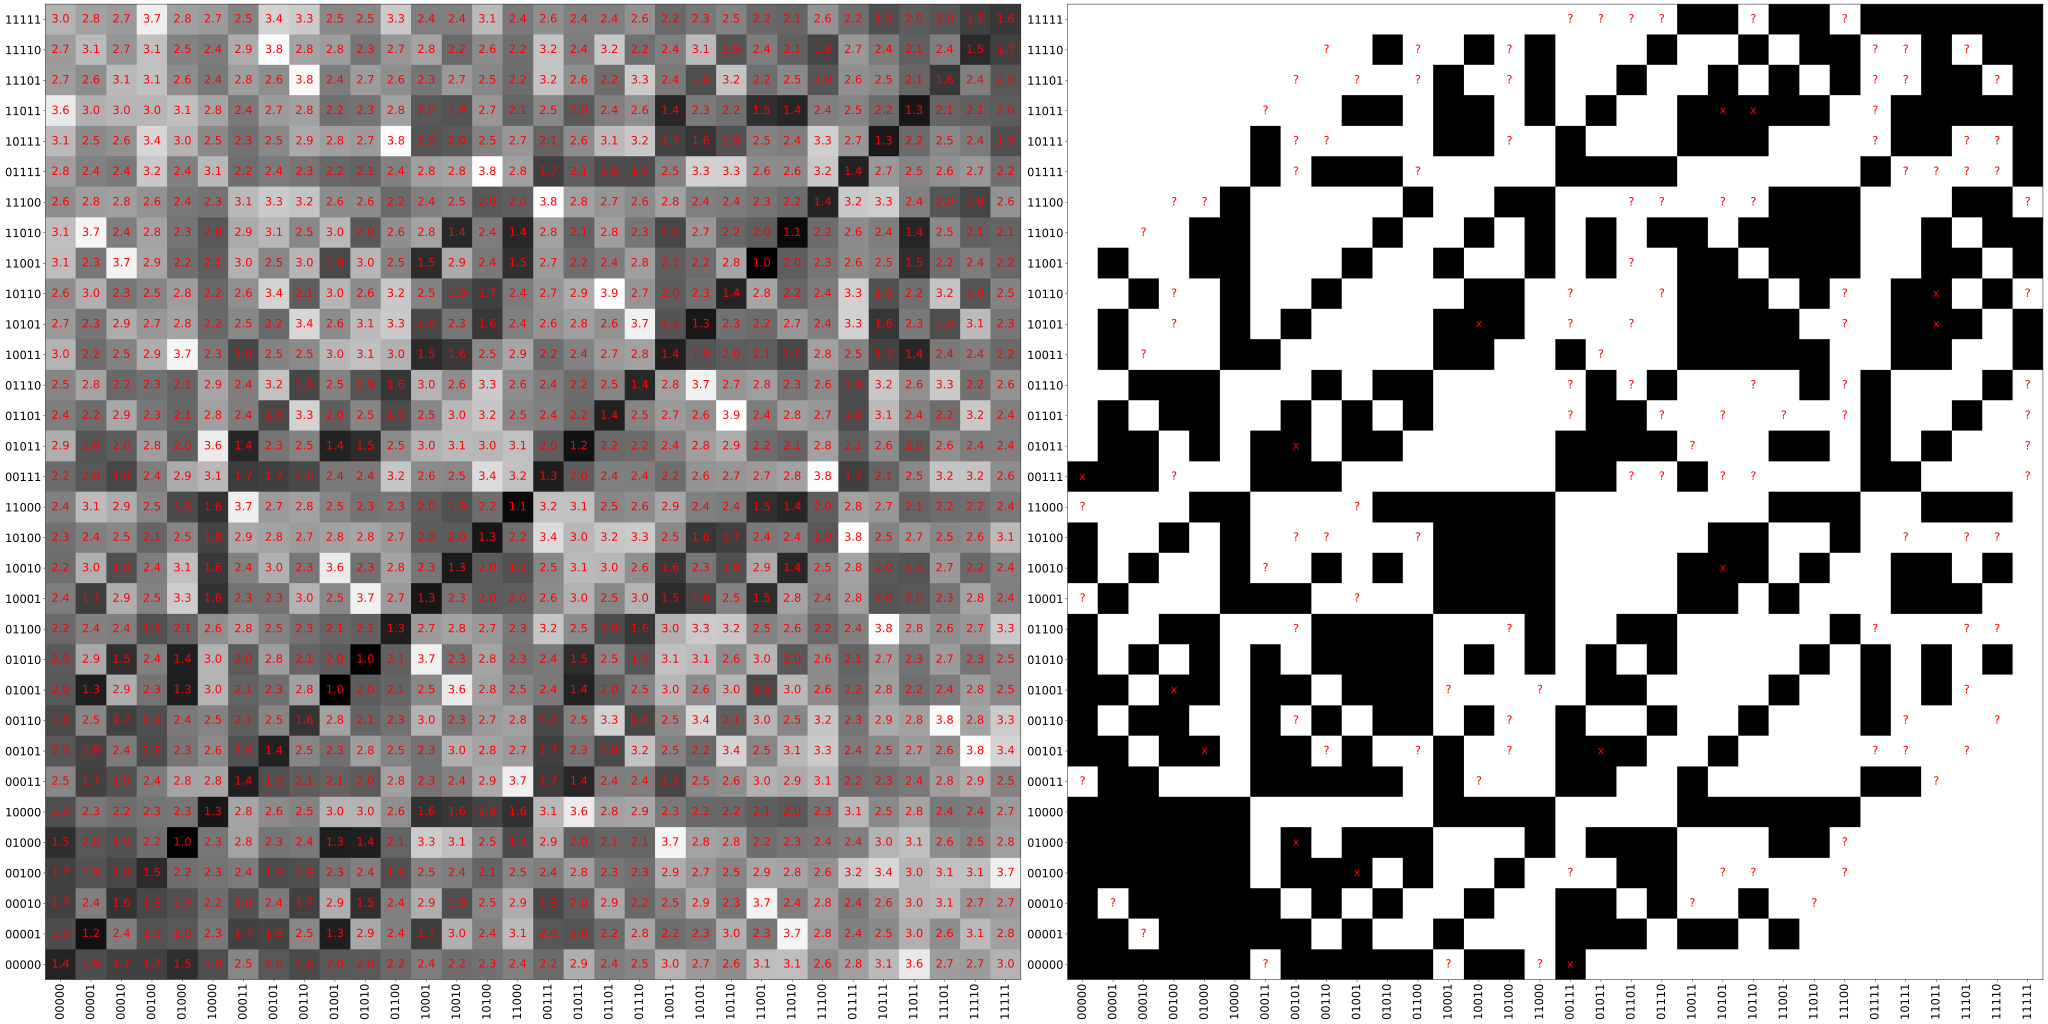

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(50, 25))

xlabels, ylabels = stringify_state(x), stringify_state(y)

heatmap(axes[0], hdist, xlabels, ylabels, annotation=hdist.round(1))
heatmap(axes[1], ~neighbors, xlabels, ylabels, annotation=errors)
fig.tight_layout()

#### Figure of tomography result for paper

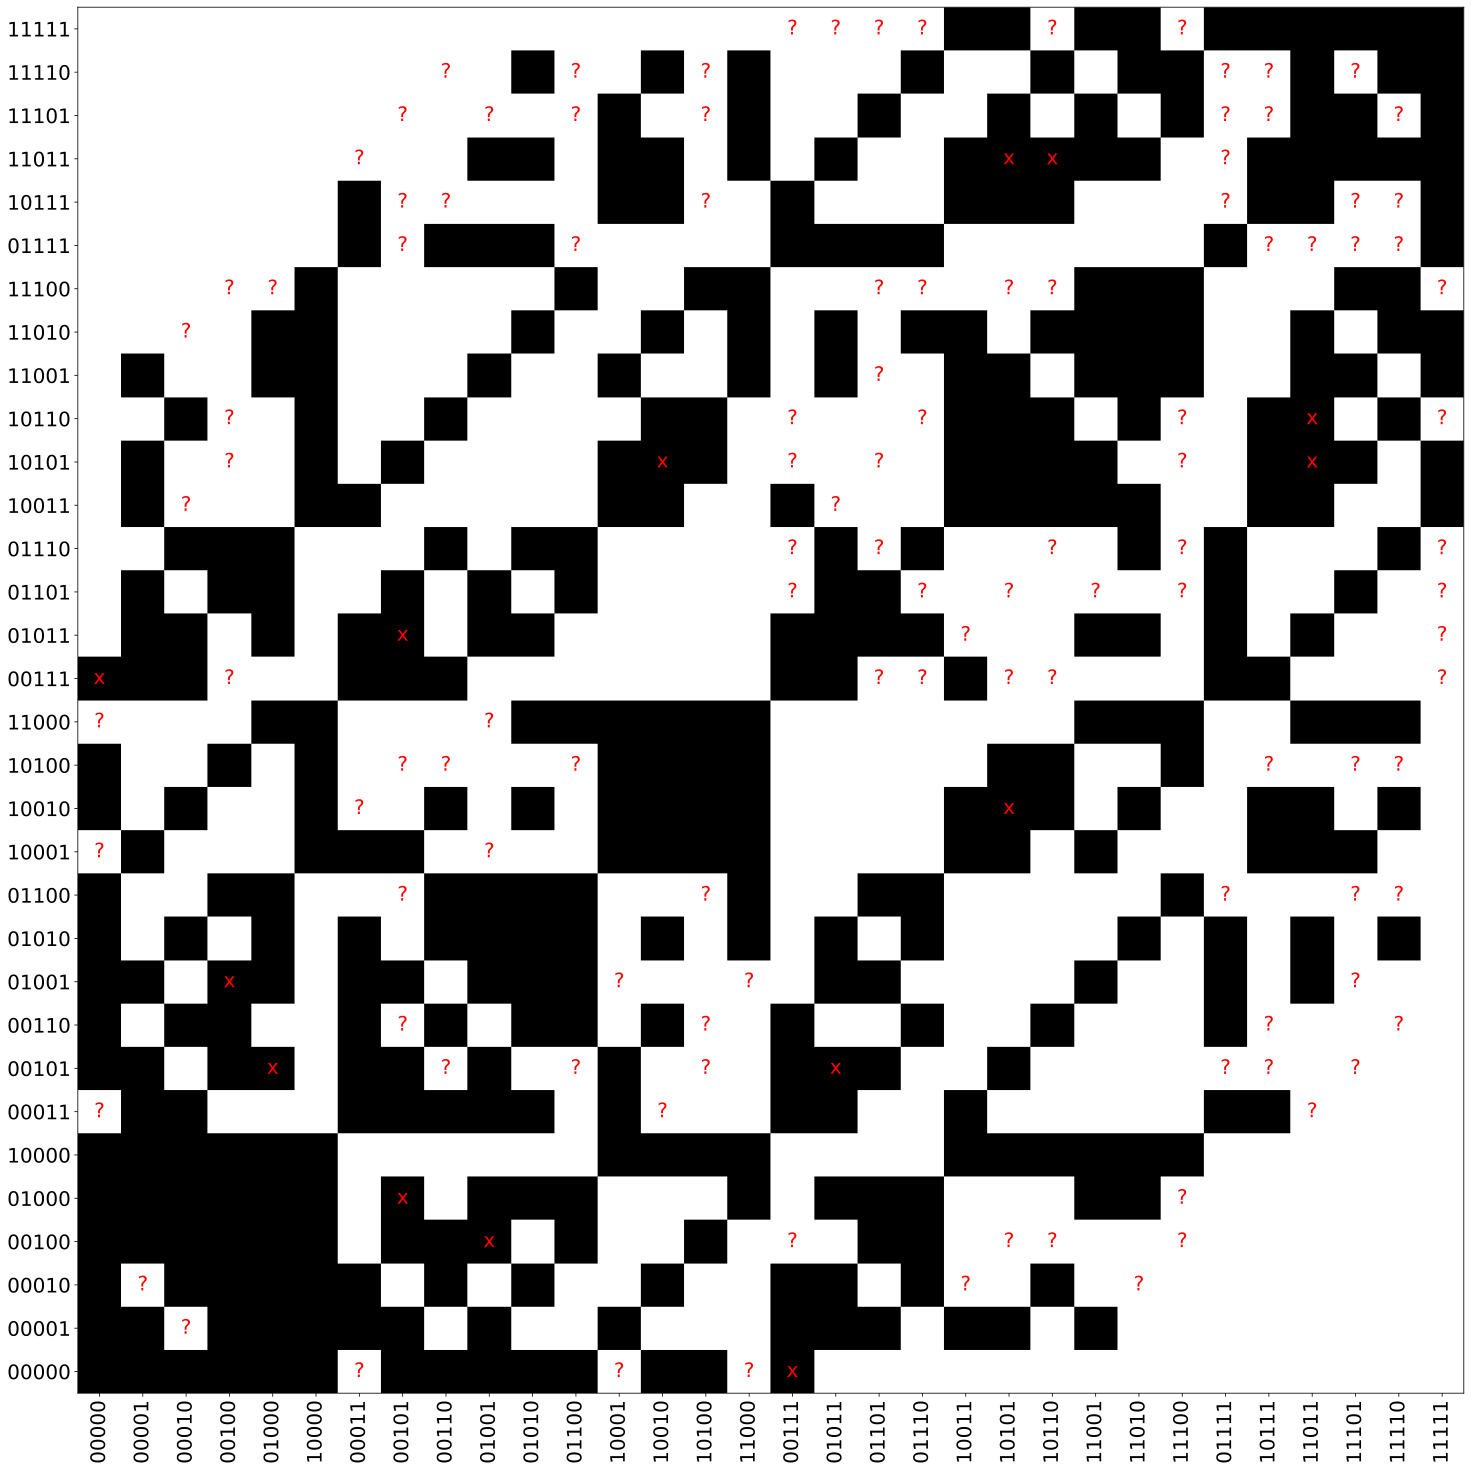

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))

xlabels, ylabels = stringify_state(x), stringify_state(y)
heatmap(ax, ~neighbors, xlabels, ylabels, annotation=errors)
fig.savefig(f"hd_tomography_n{n_data_qubits}.png", bbox_inches="tight")